# Test the $h$ function via various methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
import torch
from torch import distributions as dists
from tqdm import tqdm
import sys
sys.path.append('../')
from CDTE.cdte import CQTE
from CDTE.nuisance import KernelQuantileRegressor, RBFKernel
from Code.utils import gen_error, torch_normcdf, recursive_tensorize, get_ci, get_true_h, get_true_g
from Code import nonparamcdf as npcdf
Dist = dists.Distribution

plt.rc('font',**{'family':'sans-serif'})
#If fonttype = 1 doesn't work with LaTeX, try fonttype 42.
plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)
plt.rcParams['figure.dpi'] = 140


class MultivariateUniform(dists.Uniform):
    def __init__(self, low: float, high: float, d: int):
        super().__init__(low, high)
        self.d = d
    
    def sample(self, sample_shape=torch.Size()):
        return super().sample(torch.Size(sample_shape) + torch.Size([self.d]))
    
    def log_prob(self, value):
        return super().log_prob(value).sum(-1)


def uneven_data_gen(gs_0, gs_1, prop_score, x_base_dist: Dist, y_base_dist: Dist, n_tot: int = 2000, separate=True):
    x = x_base_dist.sample((n_tot,))
    probs = prop_score(x)
    # Indicator of whether sample is from treatment group (1)
    zerone = probs>torch.rand(n_tot)
    if separate:
        x1 = x[zerone]
        x0 = x[~zerone]
        n1 = x1.shape[0]
        n0 = x0.shape[0]
        y1 = y_base_dist.sample((n1,))
        y0 = y_base_dist.sample((n0,))
        y1 = y1 * gs_1[1](x1) + gs_1[0](x1)
        y0 = y0 * gs_0[1](x0) + gs_0[0](x0)
        return (y0, x0), (y1, x1)
    else:
        y = y_base_dist.sample((n_tot,))
        y = y * (zerone * gs_1[1](x) + (~zerone) * gs_0[1](x)) + (zerone * gs_1[0](x) + (~zerone) * gs_0[0](x))
        return (y, x, zerone.float())


def data_gen_matched(gs_0, gs_1, x_base_dist: Dist, y_base_dist: Dist, n: int = 1000):
    y0_prex = y_base_dist.sample((n,))
    y1_prex = y_base_dist.sample((n,))
    x = x_base_dist.sample((n,))
    y0 = y0_prex * gs_0[1](x) + gs_0[0](x)
    y1 = y1_prex * gs_1[1](x) + gs_1[0](x)
    return (y0, y1, x)

def exp_kernel_generator(h=1):
    return lambda x: 1/h * np.exp(-x**2/h**2/2)

Create our function to fit all aproaches and test them for given setups and test on generated data. Cross-fitting is used for each approach.

In [2]:
methods = ["separate_estimator", "ipw_estimator", "dr_estimator",
     "dr_estimator_noiso", "exact_dr_estimator", "kallus"]

def run_crossfit(gs, prop_score, base_dists, n_train, n_test, kernel_vals):
    gs_0, gs_1 = gs
    y_base_dist, x_base_dist = base_dists
    # Get related objects
    cdf_0 = lambda y, x: y_base_dist.cdf((y-gs_0[0](x))/ gs_0[1](x))
    cdf_1 = lambda y, x: y_base_dist.cdf((y-gs_1[0](x))/ gs_1[1](x))
    true_cdf0 = npcdf.exact_cdf(cdf_0)
    true_cdf1 = npcdf.exact_cdf(cdf_1)
    true_g = get_true_g(gs_0, gs_1)

    # Generate data
    data0, data1 = uneven_data_gen(gs_0, gs_1, prop_score, x_base_dist, y_base_dist, 2*n_train)
    # Cross-fitting data and objects
    data00, data01 = tuple(zip(*[torch.split(elem, int(np.ceil(elem.shape[0]/2)), dim=0) for elem in data0]))
    data10, data11 = tuple(zip(*[torch.split(elem, int(np.ceil(elem.shape[0]/2)), dim=0) for elem in data1]))
    all_xs = torch.cat((data00[1], data10[1]), dim=0)
    all_as = torch.cat((torch.zeros_like(data00[0]), torch.ones_like(data10[0])), dim=0)
    all_ys = torch.cat((data00[0], data10[0]), dim=0)
    
    # Generate test data
    alpha = torch.rand(1).item()
    test_x = x_base_dist.sample((n_test,))

    # Set up exact true g for give alpha/y sample
    def static_true_g(X):
        y_0 = y_base_dist.icdf(torch.tensor(alpha))*gs_0[1](X)+gs_0[0](X)
        return true_g(y_0, X)

    # Estimate Pseudo-Outcome Objects
    prop_kernel = npcdf.kernel.KGauss(sigma2=kernel_vals["prop"])
    CDF0_kernel = npcdf.kernel.KGauss(sigma2=kernel_vals["CDF0"])
    CDF1_kernel = npcdf.kernel.KGauss(sigma2=kernel_vals["CDF1"])
    est_prop_func = npcdf.kernel_regressor(prop_kernel, min=0.05, max=0.95)
    est_prop_func.fit(all_as, all_xs)
    est_cdf_00 = npcdf.kernel_cdf(CDF0_kernel)
    est_cdf_00.fit(*data00)
    true_cdf0.fit(*data0)
    est_cdf_10 = npcdf.kernel_cdf(CDF1_kernel)
    est_cdf_10.fit(*data10)
    true_cdf1.fit(*data1)

    # Set up Kallus Pseudo-Outcome Objects
    # Set-up objects
    propensity_model = npcdf.kernel_regressor_numpy(prop_kernel, min=0.05, max=0.95)
    RBF_scale = np.sqrt(kernel_vals["CDF0"])/2
    quantile_model = KernelQuantileRegressor(
            kernel=RBFKernel(scale=RBF_scale),
            tau=alpha)

    cond_density_kernel = exp_kernel_generator(h=1)
    cond_density_model = RandomForestRegressor(
        n_estimators=50, max_depth=5, min_samples_leaf=5, min_samples_split=10)

    ### Define Estimators ###
    # Separate Estimator
    separate_estimator = npcdf.separate_learner(est_cdf_00, est_cdf_10)
    def separate_estimator_g(X):
        y_0 = y_base_dist.icdf(torch.tensor(alpha))*gs_0[1](X)+gs_0[0](X)
        y1_est = separate_estimator.predict(y_0, X)
        return y1_est
    
    final_kernel = npcdf.kernel.KGauss(sigma2=kernel_vals["final"])

    # Pseudo IPW Estimator
    ipw_estimator = npcdf.pseudo_ipw(prop_kernel, est_prop_func)
    ipw_estimator.fit(*data01, *data11)

    def ipw_estimator_g(X):
        y_0 = y_base_dist.icdf(torch.tensor(alpha))*gs_0[1](X)+gs_0[0](X)
        y1_est = ipw_estimator.predict(y_0, X)
        return y1_est

    # DR Estimator
    dr_estimator = npcdf.dr_learner(
        final_kernel, est_cdf_00, est_cdf_10, est_prop_func)
    dr_estimator.fit(*data01, *data11)

    def dr_estimator_g(X):
        y_0 = y_base_dist.icdf(torch.tensor(alpha))*gs_0[1](X)+gs_0[0](X)
        y1_est = dr_estimator.predict(y_0, X)
        return y1_est
    
    def dr_estimator_noiso_g(X):
        y_0 = y_base_dist.icdf(torch.tensor(alpha))*gs_0[1](X)+gs_0[0](X)
        y1_est = dr_estimator.predict(y_0, X, isotonic=False)
        return y1_est

    # Exact DR Estimator
    exact_dr_estimator = npcdf.dr_learner(
        final_kernel, true_cdf0, true_cdf1, prop_score)
    exact_dr_estimator.fit(*data01, *data11)

    def exact_dr_estimator_g(X):
        y_0 = y_base_dist.icdf(torch.tensor(alpha))*gs_0[1](X)+gs_0[0](X)
        h_est = exact_dr_estimator.predict(y_0, X, linear=False)
        return h_est
    
    #### Kallus Method ####
    cqte_model = npcdf.kernel_regressor_numpy(final_kernel)
    CQTE_est = CQTE(
            propensity_model=propensity_model, 
            quantile_model=quantile_model,
            cond_density_kernel=cond_density_kernel,
            cond_density_model=cond_density_model,
            cqte_model=cqte_model, 
            tau=alpha, cv=2)
    CQTE_est.fit(all_xs.numpy(), all_as.numpy(), all_ys.numpy())

    def cqte_g(X):
        cqte_est = torch.tensor(CQTE_est.effect(X.numpy()))
        y_0 = y_base_dist.icdf(torch.tensor(alpha))*gs_0[1](X)+gs_0[0](X)
        return cqte_est + y_0

    

    # set_functions
    loss_funcs = {
        "separate_estimator": separate_estimator_g,
        "ipw_estimator": ipw_estimator_g,
        "dr_estimator": dr_estimator_g,
        "dr_estimator_noiso": dr_estimator_noiso_g,
        "exact_dr_estimator": exact_dr_estimator_g,
        "kallus": cqte_g
    }

    results = {}
    # Calculate losses
    for key, loss_func in loss_funcs.items():
        temp_loss = gen_error((test_x,), loss_func, static_true_g)
        results[key] = temp_loss
    return results

# Illustrative example

In [13]:
y_base_dist = dists.Normal(0, 1)
x_base_dist = MultivariateUniform(-1, 1, 1)
prop_score_freq = lambda x, freq: (0.4*torch.sin(freq*torch.pi*x)+.5).squeeze(-1)
gs_0_freq = (lambda x, freq: torch.sin(freq*torch.pi*x).squeeze(-1), lambda x, freq: 1)
gs_1_freq = (lambda x, freq: 2*torch.sin(freq*torch.pi*x).squeeze(-1),lambda x, freq: 2)
cdf_freq_0 = lambda y, x, freq: y_base_dist.cdf((y-gs_0_freq[0](x, freq))/ gs_0_freq[1](x, freq))
cdf_freq_1 = lambda y, x, freq: y_base_dist.cdf((y-gs_1_freq[0](x, freq))/ gs_1_freq[1](x, freq))
cdf_inv_freq_0 = lambda alpha, x, freq: y_base_dist.icdf(alpha)*gs_0_freq[1](x, freq)+gs_0_freq[0](x, freq)
cdf_inv_freq_1 = lambda alpha, x, freq: y_base_dist.icdf(alpha)*gs_1_freq[1](x, freq)+gs_1_freq[0](x, freq)

## Plot estimands

## Varying Frequency

In [31]:
savedir = os.path.join("TestResults", "IllustrativeExample", "VaryingComplexity")
freqs = [0, 2, 4, 6, 8, 10]
results_dict = {key: [] for key in methods}
n = 500
nrep = 500

for j, freq in enumerate(freqs):
    # Set-up problem and hyper parameters
    prop_score = lambda x: prop_score_freq(x, freq)
    gs_0 = (lambda x: gs_0_freq[0](x, freq), lambda x: gs_0_freq[1](x, freq))
    gs_1 = (lambda x: gs_1_freq[0](x, freq), lambda x: gs_1_freq[1](x, freq))
    temp_hyper_vals = { key: 0.01/(np.maximum(freq, 1)) for key in ["prop", "CDF0", "CDF1"]}
    temp_hyper_vals["final"] = .5
    
    for i in tqdm(range(nrep)):
        # Run and get errors
        temp_results = run_crossfit(
            (gs_0, gs_1), prop_score, (y_base_dist, x_base_dist), 
            n_train = n, n_test = 10, kernel_vals=temp_hyper_vals)
        # Store results
        for key in results_dict.keys():
            results_dict[key].append(temp_results[key])

# Make tensor and reshape and save
results_dict = {key: recursive_tensorize(val).reshape(len(freqs), nrep) 
                for key, val in results_dict.items()}
        
os.makedirs(savedir, exist_ok=True)
torch.save(results_dict, os.path.join(savedir, "results.pt"))

100%|██████████| 500/500 [02:34<00:00,  3.23it/s]


## Varying N

In [ ]:
savedir = os.path.join("TestResults", "IllustrativeExample", "VaryingSampleSize")
freq = 6
# Set-up problem
prop_score = lambda x: prop_score_freq(x, freq)
gs_0 = (lambda x: gs_0_freq[0](x, freq), lambda x: gs_0_freq[1](x, freq))
gs_1 = (lambda x: gs_1_freq[0](x, freq), lambda x: gs_1_freq[1](x, freq))

# Get related objects
true_cdf0 = npcdf.exact_cdf(lambda y, x: cdf_freq_0(y, x, freq))
true_cdf1 = npcdf.exact_cdf(lambda y, x: cdf_freq_1(y, x, freq))
true_g = get_true_g(gs_0, gs_1)

temp_hyper_vals = {key: 0.01/(np.maximum(freq, 1)) for key in ["prop", "CDF0", "CDF1"]}
temp_hyper_vals["final"] = .5

ns = [200,500,1000,2000,5000]
results_dict = {key: [] for key in methods}

for n in ns:
    for i in tqdm(range(500)):
        temp_results = run_crossfit(
            (gs_0, gs_1), prop_score, (y_base_dist, x_base_dist), 
            n_train = n, n_test = 10, kernel_vals=temp_hyper_vals)
        # Store results
        for key in results_dict.keys():
            results_dict[key].append(temp_results[key])



# Make tensor and reshape and save
results_dict = {key: recursive_tensorize(val).reshape(len(ns), nrep) 
                for key, val in results_dict.items()}
        
os.makedirs(savedir, exist_ok=True)
torch.save(results_dict, os.path.join(savedir, "results.pt"))

# 10DimExample

In [3]:
y_base_dist = dists.Normal(0, 1)
x_base_dist = MultivariateUniform(-1, 1, 10)

torch.manual_seed(123)
coef_vector = torch.randn(10)/5
# Find gradient in steepest direction of length sqrt{d}
print(np.sqrt(10.)*torch.sum(coef_vector**2)/torch.linalg.norm(coef_vector))

prop_score_freq = lambda x, freq: (0.4*torch.sin(freq*torch.pi*(x@coef_vector))+.5)
gs_0_freq = (lambda x, freq: (torch.sin(freq*torch.pi*(x@coef_vector))+.5),
             lambda x, freq: 1)
gs_1_freq = (lambda x, freq: (torch.sin(freq*torch.pi*(x@coef_vector))),
             lambda x, freq: 1)
cdf_freq_0 = lambda y, x, freq: y_base_dist.cdf((y-gs_0_freq[0](x, freq))/ gs_0_freq[1](x, freq))
cdf_freq_1 = lambda y, x, freq: y_base_dist.cdf((y-gs_1_freq[0](x, freq))/ gs_1_freq[1](x, freq))

tensor(1.1541)


Find optimal kernel values

In [4]:
n=500
freqs = np.linspace(0,3,7)
prop_score = lambda x: prop_score_freq(x, freq)
gs_0 = (lambda x: gs_0_freq[0](x, freq), lambda x: gs_0_freq[1](x, freq))
gs_1 = (lambda x: gs_1_freq[0](x, freq), lambda x: gs_1_freq[1](x, freq))

# Get related objects
true_cdf0 = npcdf.exact_cdf(lambda y, x: cdf_freq_0(y, x, freq))
true_cdf1 = npcdf.exact_cdf(lambda y, x: cdf_freq_1(y, x, freq))
true_g = get_true_g(gs_0, gs_1)

kernel_vals = np.linspace(0.1, 2, 20)
cross_val_dict = {
    "prop": [],
    "CDF0": [],
    "CDF1": []}
# Loop over frequencies
for freq in freqs:
    # Add empty list for results for this frequency
    for key in cross_val_dict.keys():
        cross_val_dict[key].append([])
    # Loop over kernel values
    for kernel_val in kernel_vals:
        for key in cross_val_dict.keys():
            cross_val_dict[key][-1].append([])
        for i in tqdm(range(500)):
            # Generate data
            data0, data1 = uneven_data_gen(gs_0, gs_1, prop_score, x_base_dist, y_base_dist, 2*n)
            # Cross-fitting data and objects
            data00, data01 = tuple(zip(*[torch.split(elem, int(np.ceil(elem.shape[0]/2)), dim=0) for elem in data0]))
            data10, data11 = tuple(zip(*[torch.split(elem, int(np.ceil(elem.shape[0]/2)), dim=0) for elem in data1]))
            adaptive_kernel = npcdf.kernel.KGauss(sigma2=kernel_val)
            all_xs = torch.cat((data00[1], data10[1]), dim=0)
            all_as = torch.cat((torch.zeros_like(data00[0]), torch.ones_like(data10[0])), dim=0)
            
            est_cdf_00 = npcdf.kernel_cdf(adaptive_kernel)
            est_cdf_00.fit(*data00)
            true_cdf0.fit(*data0)
            est_cdf_10 = npcdf.kernel_cdf(adaptive_kernel)
            est_cdf_10.fit(*data10)
            true_cdf1.fit(*data1)

            # Estimate Pseudo-Outcome Objects
            est_prop_func = npcdf.kernel_regressor(adaptive_kernel, min=0.05, max=0.95)
            est_prop_func.fit(all_as, all_xs)

                    # Generate test data
            test_y0, test_y1, test_x = data_gen_matched(gs_0, gs_1, x_base_dist, y_base_dist, 10)
            temp_prop_loss = gen_error((test_x), est_prop_func, prop_score)
            cross_val_dict["prop"][-1][-1].append(temp_prop_loss)
            temp_CDF0_loss = gen_error((test_y0, test_x), est_cdf_00, true_cdf0)
            cross_val_dict["CDF0"][-1][-1].append(temp_CDF0_loss)
            temp_CDF1_loss = gen_error((test_y1, test_x), est_cdf_10, true_cdf1)
            cross_val_dict["CDF1"][-1][-1].append(temp_CDF1_loss)

cross_val_cis = {key: torch.mean(recursive_tensorize(val),dim=-1) for key, val in cross_val_dict.items()}
hyper_vals = {} 
for key in cross_val_cis:
    print(key)
    temp_val = kernel_vals[torch.argmin(cross_val_cis[key], dim=-1)]
    print(temp_val)
    hyper_vals[key] = temp_val

  1%|          | 3/500 [00:00<01:13,  6.78it/s]

100%|██████████| 500/500 [00:26<00:00, 18.92it/s]


prop
[2.  1.4 0.8 0.7 0.6 0.7 0.6]
CDF0
[2.  1.6 1.1 1.1 1.  1.3 1.2]
CDF1
[2.  1.9 1.2 1.  1.2 1.1 1.5]


## Varying complexity ($\gamma$)

In [5]:
savedir = os.path.join("TestResults", "10DimExample", "VaryingComplexity")
freqs = torch.linspace(0, 3, 7)
results_dict = {key: [] for key in methods}
n = 500
nrep = 500
for j, freq in enumerate(freqs):
    # Set-up problem
    prop_score = lambda x: prop_score_freq(x, freq)
    gs_0 = (lambda x: gs_0_freq[0](x, freq), lambda x: gs_0_freq[1](x, freq))
    gs_1 = (lambda x: gs_1_freq[0](x, freq), lambda x: gs_1_freq[1](x, freq))
    temp_hyper_vals = {key: val[j] for key, val in hyper_vals.items()}
    temp_hyper_vals["final"] = 5
    for i in tqdm(range(nrep)):
        # Run and get errors
        temp_results = run_crossfit(
            (gs_0, gs_1), prop_score, (y_base_dist, x_base_dist), 
            n_train = n, n_test = 10, kernel_vals=temp_hyper_vals)

        for key in results_dict.keys():
            results_dict[key].append(temp_results[key])

# Reshape and save
results_dict = {key: recursive_tensorize(val).reshape(freqs.shape[-1], nrep) 
                for key, val in results_dict.items()}
        
os.makedirs(savedir, exist_ok=True)
torch.save(results_dict, os.path.join(savedir, "results.pt"))

100%|██████████| 500/500 [09:35<00:00,  1.15s/it]


## Varying sample size ($n$)

In [15]:
savedir = os.path.join("TestResults", "10DimExample", "VaryingSampleSize")
freq = 1
freq_index = 2
results_dict = {key: [] for key in methods}

# Set-up problem
prop_score = lambda x: prop_score_freq(x, freq)
gs_0 = (lambda x: gs_0_freq[0](x, freq), lambda x: gs_0_freq[1](x, freq))
gs_1 = (lambda x: gs_1_freq[0](x, freq), lambda x: gs_1_freq[1](x, freq))
temp_hyper_vals = {key: val[freq_index] for key, val in hyper_vals.items()}
temp_hyper_vals["final"] = 5
ns = [200,500,1000,2000,5000]
nrep = 500

for n in ns:
    for i in tqdm(range(nrep)):
        # Run and get errors
        temp_results = run_crossfit(
            (gs_0, gs_1), prop_score, (y_base_dist, x_base_dist), 
            n_train = n, n_test = 10, kernel_vals=temp_hyper_vals)

        # Store results
        for key in results_dict.keys():
            results_dict[key].append(temp_results[key])

# Reshape and save
results_dict = {key: recursive_tensorize(val).reshape(len(ns), nrep) 
                for key, val in results_dict.items()}
        
os.makedirs(savedir, exist_ok=True)
torch.save(results_dict, os.path.join(savedir, "results.pt"))

100%|██████████| 500/500 [48:34<00:00,  5.83s/it]


# Linear CQC
Set up distributions

In [17]:
y_base_dist = dists.Normal(0, 1)
x_base_dist = MultivariateUniform(-1, 1, 1)
prop_score_freq = lambda x, freq: (0.4*torch.sin(freq*torch.pi*x)+.5).squeeze(-1)
gs_0_freq = (lambda x, freq: (torch.sin(freq*torch.pi*x)/(.5*x+1.5)).squeeze(-1), 
            #  lambda x, freq: torch.exp(0.3*x).squeeze(-1))
             lambda x, freq: 1)
gs_1_freq = (lambda x, freq: (torch.sin(freq*torch.pi*x)+ .25*x+0.75).squeeze(-1),
            #  lambda x, freq: torch.exp(0.3*x).squeeze(-1))
             lambda x, freq: (.5*x+1.5).squeeze(-1))
cdf_freq_0 = lambda y, x, freq: y_base_dist.cdf((y-gs_0_freq[0](x, freq))/ gs_0_freq[1](x, freq))
cdf_freq_1 = lambda y, x, freq: y_base_dist.cdf((y-gs_1_freq[0](x, freq))/ gs_1_freq[1](x, freq))

### Hyperparameter Selection

In [20]:
n=500
freqs = [0, 2, 4, 6, 8, 10]
prop_score = lambda x: prop_score_freq(x, freq)
gs_0 = (lambda x: gs_0_freq[0](x, freq), lambda x: gs_0_freq[1](x, freq))
gs_1 = (lambda x: gs_1_freq[0](x, freq), lambda x: gs_1_freq[1](x, freq))

# Get related objects
true_cdf0 = npcdf.exact_cdf(lambda y, x: cdf_freq_0(y, x, freq))
true_cdf1 = npcdf.exact_cdf(lambda y, x: cdf_freq_1(y, x, freq))
true_g = get_true_g(gs_0, gs_1)
true_h = get_true_h(gs_0, gs_1, base_cdf=torch_normcdf)

kernel_vals = np.linspace(0.001, 0.02, 20)
cross_val_dict = {
    "prop": [],
    "CDF0": [],
    "CDF1": [],
    "h": []}
# Loop over frequencies
for j, freq in enumerate(freqs):
    # Add empty list for results for this frequency
    for key in cross_val_dict.keys():
        cross_val_dict[key].append([])
    # Loop over kernel values
    for kernel_val in kernel_vals:
        for key in cross_val_dict.keys():
            cross_val_dict[key][-1].append([])
        for i in range(50):
            # Generate data
            data0, data1 = uneven_data_gen(gs_0, gs_1, prop_score, x_base_dist, y_base_dist, 2*n)
            # Cross-fitting data and objects
            data00, data01 = tuple(zip(*[torch.split(elem, int(np.ceil(elem.shape[0]/2)), dim=0) for elem in data0]))
            data10, data11 = tuple(zip(*[torch.split(elem, int(np.ceil(elem.shape[0]/2)), dim=0) for elem in data1]))
            adaptive_kernel = npcdf.kernel.KGauss(sigma2=kernel_val)
            all_xs = torch.cat((data00[1], data10[1]), dim=0)
            all_as = torch.cat((torch.zeros_like(data00[0]), torch.ones_like(data10[0])), dim=0)
            
            est_cdf_00 = npcdf.kernel_cdf(adaptive_kernel)
            est_cdf_00.fit(*data00)
            est_cdf_10 = npcdf.kernel_cdf(adaptive_kernel)
            est_cdf_10.fit(*data10)

            # Estimate Pseudo-Outcome Objects
            est_prop_func = npcdf.kernel_regressor(adaptive_kernel, min=0.05, max=0.95)
            est_prop_func.fit(all_as, all_xs)

            dr_estimator = npcdf.dr_learner(
                adaptive_kernel, true_cdf0, true_cdf1, prop_score)
            dr_estimator.fit(*data0, *data1)
            def h_est(y_0, y_1, X):
                return dr_estimator.get_single_h(y_0, y_1, X)

                    # Generate test data
            test_y0, test_y1, test_x = data_gen_matched(gs_0, gs_1, x_base_dist, y_base_dist, 10)
            temp_prop_loss = gen_error((test_x), est_prop_func, prop_score)
            cross_val_dict["prop"][-1][-1].append(temp_prop_loss)
            temp_CDF0_loss = gen_error((test_y0, test_x), est_cdf_00, true_cdf0)
            cross_val_dict["CDF0"][-1][-1].append(temp_CDF0_loss)
            temp_CDF1_loss = gen_error((test_y1, test_x), est_cdf_10, true_cdf1)
            cross_val_dict["CDF1"][-1][-1].append(temp_CDF1_loss)
            temp_h_loss = gen_error((test_y0, test_y1, test_x), h_est, true_h)
            cross_val_dict["h"][-1][-1].append(temp_h_loss)

cross_val_cis = {key: torch.mean(recursive_tensorize(val),dim=-1) for key, val in cross_val_dict.items()}
hyper_vals = {} 
for key in cross_val_cis:
    print(key)
    temp_val = kernel_vals[torch.argmin(cross_val_cis[key], dim=-1)]
    print(temp_val)
    hyper_vals[key] = temp_val
torch.save(hyper_vals, os.path.join("TestResults","LinearCQCExample","hyper_vals.pt"))

prop
[0.02  0.009 0.003 0.001 0.001 0.001]
CDF0
[0.019 0.02  0.006 0.004 0.003 0.001]
CDF1
[0.018 0.015 0.007 0.005 0.003 0.002]
h
[0.02  0.018 0.02  0.019 0.015 0.017]


## Varying complexity ($\gamma$)

In [21]:
savedir = os.path.join("TestResults", "LinearCQCExample", "VaryingComplexity")
freqs = [0, 2, 4, 6, 8, 10]
results_dict = {key: [] for key in methods}
n = 500
nrep = 500
for j,freq in tqdm(enumerate(freqs)):
    # Set-up problem
    prop_score = lambda x: prop_score_freq(x, freq)
    gs_0 = (lambda x: gs_0_freq[0](x, freq), lambda x: gs_0_freq[1](x, freq))
    gs_1 = (lambda x: gs_1_freq[0](x, freq), lambda x: gs_1_freq[1](x, freq))
    temp_hyper_vals = {key: val[j] for key, val in hyper_vals.items()}
    temp_hyper_vals["final"] = 0.1
    for i in range(500):
 # Run and get errors
        temp_results = run_crossfit(
            (gs_0, gs_1), prop_score, (y_base_dist, x_base_dist), 
            n_train = n, n_test = 10, kernel_vals=temp_hyper_vals)

        for key in results_dict.keys():
            results_dict[key].append(temp_results[key])

# Reshape and save
results_dict = {key: recursive_tensorize(val).reshape(len(freqs), nrep) 
                for key, val in results_dict.items()}
        
os.makedirs(savedir, exist_ok=True)
torch.save(results_dict, os.path.join(savedir, "results.pt"))

6it [09:03, 90.59s/it]


## Varying sample size ($n$)

In [ ]:
savedir = os.path.join("TestResults", "LinearCQCExample", "VaryingSampleSize")
freq = 6
freq_index = 3
results_dict = {key: [] for key in methods}

# Set-up problem
prop_score = lambda x: prop_score_freq(x, freq)
gs_0 = (lambda x: gs_0_freq[0](x, freq), lambda x: gs_0_freq[1](x, freq))
gs_1 = (lambda x: gs_1_freq[0](x, freq), lambda x: gs_1_freq[1](x, freq))
temp_hyper_vals = {key: val[freq_index] for key, val in hyper_vals.items()}
temp_hyper_vals["final"] = 0.1

ns = [200,500,1000,2000,5000]
nrep = 500

for n in ns:
    # Add empty list for results for this frequency
    for i in range(500):
        # Run and get errors
        temp_results = run_crossfit(
            (gs_0, gs_1), prop_score, (y_base_dist, x_base_dist), 
            n_train = n, n_test = 10, kernel_vals=temp_hyper_vals)

        # Store results
        for key in results_dict.keys():
            results_dict[key].append(temp_results[key])

# Reshape and save
results_dict = {key: recursive_tensorize(val).reshape(len(ns), nrep) 
                for key, val in results_dict.items()}
        
os.makedirs(savedir, exist_ok=True)
torch.save(results_dict, os.path.join(savedir, "results.pt"))


# Constant $h^*$ Example
We now adapt our original example to have a uniform base distribution. This makes $h^*$ constant w.r.t $x$ as well unlike in the normal case. 

In [50]:
class NewUniform(dists.Distribution):
    def __init__(self, low, high):
        self.low = low
        self.high = high
        self.uniform = dists.Uniform(0,1)
    def sample(self, n):
        return self.low + (self.high-self.low)*self.uniform.sample(n)
    def cdf(self, x):
        return torch.clamp((x-self.low)/(self.high-self.low), 0.,1.)
    def icdf(self, x):
        return self.low + x*(self.high-self.low)
    def log_prob(self, x):
        return torch.log(1/(self.high-self.low))


In [51]:
y_base_dist = NewUniform(0, 1)
x_base_dist = MultivariateUniform(-1, 1, 1)
prop_score_freq = lambda x, freq: (0.4*torch.sin(freq*torch.pi*x)+.5).squeeze(-1)
gs_0_freq = (lambda x, freq: torch.sin(freq*torch.pi*x).squeeze(-1), lambda x, freq: 1)
gs_1_freq = (lambda x, freq: 2*torch.sin(freq*torch.pi*x).squeeze(-1),lambda x, freq: 2)
cdf_freq_0 = lambda y, x, freq: torch.clamp((y-gs_0_freq[0](x, freq))/ gs_0_freq[1](x, freq),0,1)
cdf_freq_1 = lambda y, x, freq: torch.clamp((y-gs_1_freq[0](x, freq))/ gs_1_freq[1](x, freq),0,1)

## Varying Frequency

In [52]:
savedir = os.path.join("TestResults", "IllustrativeUnifExample", "VaryingComplexity")
freqs = [0, 2, 4, 6, 8, 10]
results_dict = {key: [] for key in methods}
n = 500
nrep = 500
for j, freq in enumerate(freqs):
    # Set-up problem and hyper parameters
    prop_score = lambda x: prop_score_freq(x, freq)
    gs_0 = (lambda x: gs_0_freq[0](x, freq), lambda x: gs_0_freq[1](x, freq))
    gs_1 = (lambda x: gs_1_freq[0](x, freq), lambda x: gs_1_freq[1](x, freq))
    temp_hyper_vals = {key: 0.01/(np.maximum(freq, 1)) for key in ["prop", "CDF0", "CDF1"]}
    temp_hyper_vals["final"] = .5
    for i in tqdm(range(nrep)):
        # Run and get errors
        temp_results = run_crossfit(
            (gs_0, gs_1), prop_score, (y_base_dist, x_base_dist), 
            n_train = n, n_test = 10, kernel_vals=temp_hyper_vals)
        # Store results
        for key in results_dict.keys():
            results_dict[key].append(temp_results[key])

# Make tensor and reshape and save
results_dict = {key: recursive_tensorize(val).reshape(len(freqs), nrep) 
                for key, val in results_dict.items()}
        
os.makedirs(savedir, exist_ok=True)
torch.save(results_dict, os.path.join(savedir, "results.pt"))

100%|██████████| 500/500 [01:23<00:00,  6.02it/s]


## Varying N

In [54]:
savedir = os.path.join("TestResults", "IllustrativeUnifExample", "VaryingSampleSize")
freq = 6
# Set-up problem
prop_score = lambda x: prop_score_freq(x, freq)
gs_0 = (lambda x: gs_0_freq[0](x, freq), lambda x: gs_0_freq[1](x, freq))
gs_1 = (lambda x: gs_1_freq[0](x, freq), lambda x: gs_1_freq[1](x, freq))

temp_hyper_vals = {key: 0.01/(np.maximum(freq, 1)) for key in ["prop", "CDF0", "CDF1"]}
temp_hyper_vals["final"] = .5
ns = [200,500,1000,2000,5000]
results_dict = {key: [] for key in methods}

for n in ns:
    for i in tqdm(range(500)):
        temp_results = run_crossfit(
            (gs_0, gs_1), prop_score, (y_base_dist, x_base_dist), 
            n_train = n, n_test = 10, kernel_vals=temp_hyper_vals)
        # Store results
        for key in results_dict.keys():
            results_dict[key].append(temp_results[key])


# Make tensor and reshape and save
results_dict = {key: recursive_tensorize(val).reshape(len(ns), nrep) 
                for key, val in results_dict.items()}
        
os.makedirs(savedir, exist_ok=True)
torch.save(results_dict, os.path.join(savedir, "results.pt"))

100%|██████████| 500/500 [43:08<00:00,  5.18s/it] 


# Initial Illustration

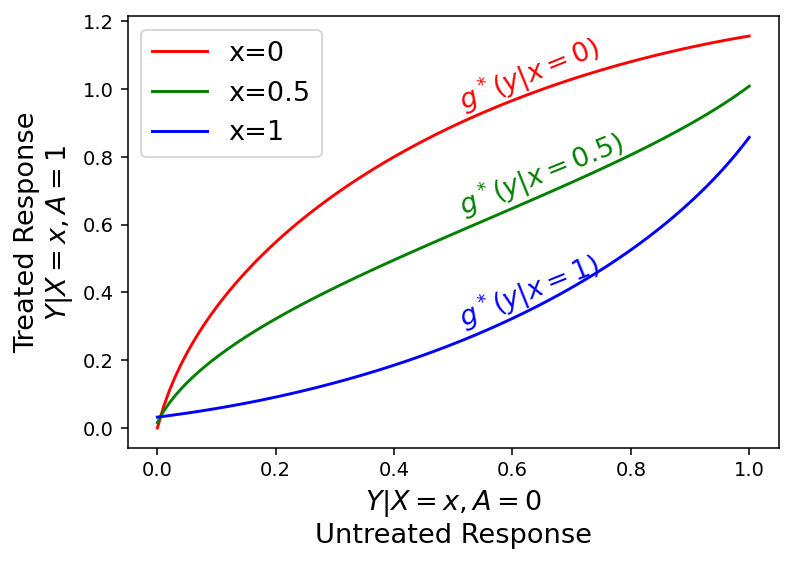

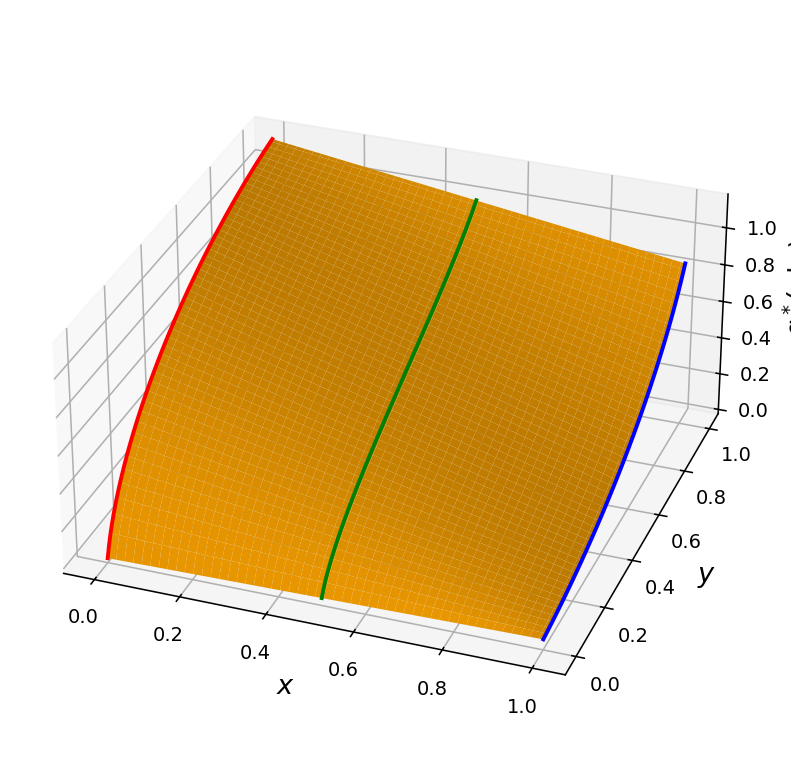

In [56]:
g = lambda y,x: (1-x)*(-0.2+np.sqrt(2-(y-1.4)**2))+(x)*(np.sqrt(2)-np.sqrt(2-(y+0.3)**2))
# Define the range of x and y
x_range = np.linspace(0, 1, 100)
y_range = np.linspace(0, 1, 100)

# Create a grid of x and y values
X, Y = np.meshgrid(x_range, y_range)

# Evaluate the cdf_0 function at each point in the grid
Z_g = np.array([[g(y,x) for x, y in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

# Define specific values of x for slices
x_slice_1 = 0
x_slice_3 = 0.5
x_slice_2 = 1
 
# Get the corresponding indices for the x values in the meshgrid
idx_1 = np.abs(x_range - x_slice_1).argmin()
idx_2 = np.abs(x_range - x_slice_2).argmin()
idx_3 = np.abs(x_range - x_slice_3).argmin()

# Extract the curves at these x values
Y_slice_1 = Y[:, idx_1]
Z_slice_1 = Z_g[:, idx_1]
Y_slice_2 = Y[:, idx_2]
Z_slice_2 = Z_g[:, idx_2]
Y_slice_3 = Y[:, idx_3]
Z_slice_3 = Z_g[:, idx_3]
 
fig, ax = plt.subplots(figsize=(6, 4))
# Plot the slices
ax.plot(Y_slice_1, Z_slice_1, color='red', label=f'x={x_slice_1}')
ax.plot(Y_slice_3, Z_slice_3, color='green', label=f'x={x_slice_3}')
ax.plot(Y_slice_2, Z_slice_2, color='blue', label=f'x={x_slice_2}')
# Add labels at specific points on plot with matching colors as the lines
ax.annotate(r'$g^*(y|x=0)$', (0.5, 0.94), color='red', fontsize=14, rotation=22)
ax.annotate(r'$g^*(y|x=0.5)$', (0.5, 0.63), color='green', fontsize=14, rotation=22)
ax.annotate(r'$g^*(y|x=1)$', (0.5, 0.3), color='blue', fontsize=14, rotation=22)
ax.set_ylabel("Treated Response"+"\n" r"$Y|X=x,A=1$",fontsize=14)
ax.set_xlabel(r"$Y|X=x,A=0$"+"\n"+"Untreated Response",fontsize=14)
ax.legend(fontsize=14)
fig.savefig("../Plots/NonLinearCQCExample_gSlices.pdf", bbox_inches='tight')

# Create the surface plot with highlighted slices
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 0.5])
# Plot the slices
ax.plot([x_slice_1]*len(Y_slice_1), Y_slice_1, Z_slice_1, color='red', label=f'x={x_slice_1}', linewidth=2,zorder=10)
ax.plot([x_slice_3]*len(Y_slice_3), Y_slice_3, Z_slice_3, color='green', label=f'x={x_slice_3}', linewidth=2,zorder=10)
ax.plot([x_slice_2]*len(Y_slice_2), Y_slice_2, Z_slice_2, color='blue', label=f'x={x_slice_2}', linewidth=2,zorder=10)
surface = ax.plot_surface(X, Y, Z_g, alpha=1, color="orange")
# Set labels
ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$y$', fontsize=14)
ax.set_zlabel(r'$g^*(y|x)$', fontsize=14)
# Add legend
# ax.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95), fontsize=14)
ax.view_init(30, -70)
extra_artists = ax.get_xaxis().get_label(), ax.get_yaxis().get_label(), ax.get_zaxis().get_label()
plt.show()
fig.savefig("../Plots/NonLinearCQCExample_gSurface.pdf", bbox_inches='tight', bbox_extra_artists=extra_artists)